# Hyperparams

In [103]:
import torch
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path =     '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames'
pretrain_path_imgs = '/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames/class_0'
val_path =          "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames"
val_path_imgs =     "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/validation_frames/class_0"
run_name =          "mask_ratio=0.5 (ned fra 0.75), derefter tsne"
num_epochs =        100
dim =               224
batch_size =        32
mask_ratio =        0.50
training =          False
fine_tuning =       True
load_prev_model =   True
load_prev_model_path = "/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/models/mae_checkpoint_epoch-60_7198_mask-0.5.pth"
tsne_plotting =     True
tsne_target =       "training images"
plot_single_image = False
plot_16_images =    False
get_num_params =    False
break_after_num_steps = -1

## Dataset

In [104]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
#import torch.optim as optim #bruger prodigy
from torch.utils.data import DataLoader
import numpy as np
from prodigyopt import Prodigy
import lightning as L

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block
from tqdm import tqdm

# class CustomFramesDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.images = []
#         for class_dir in os.listdir(root_dir):
#             class_path = os.path.join(root_dir, class_dir)
#             if os.path.isdir(class_path):
#                 for img_name in os.listdir(class_path):
#                     img_path = os.path.join(class_path, img_name)
#                     image = Image.open(img_path).convert("RGB")
#                     if self.transform:
#                         image = self.transform(image)
#                     self.images.append(image)
#         print(f"Loaded {len(self.images)} images.") # Debugging line

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         return self.images[idx]

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((dim, dim)), # Resize the image to #32x32
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

#dataset = CustomFramesDataset(root_dir=frames_path, transform=transform)
dataset = ImageFolder(
        pretrain_path,
        transform=transform,
    )

val_dataset = ImageFolder(
        val_path,
        transform=transform,
    ) 

# model architecture + help fn

In [105]:
## ViT Model + functions
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        
        # Calculate the number of patches
        num_patches = patches.shape[0]
        

        
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=dim,
                 patch_size=16,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=mask_ratio,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=4) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
    

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes
    
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

def mask_image(image, mask_size):
    mask = torch.ones_like(image)
    mask[:, :mask_size, :mask_size] = 0
    return image * mask

## load model if it exists

In [106]:
def load_model():
    import torch
    import os

    if os.path.exists(load_prev_model_path):
        # Load the checkpoint
        checkpoint = torch.load(load_prev_model_path)
        
        # Load the model state dict
        model = MAE_ViT().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state dict
        optimizer = Prodigy(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load the loss
        loss = checkpoint['loss']
        
        print(f"Model loaded with loss: {loss}")
    else:
        model = MAE_ViT().to(device)
        print("Model checkpoint not found. Init model from scratch.")
    return model, optimizer, loss

if load_prev_model:
    model, optimizer, loss = load_model()
else:
    model = MAE_ViT().to(device)
    optimizer = Prodigy(model.parameters())
    #loss er custom mse loss

Model loaded with loss: 0.008404879830777645


### Num_params in model

In [107]:
if get_num_params:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")

# Pre-Train model:

In [108]:
if training:    #Tensorboard writer
    writer = SummaryWriter(os.path.join("logs", "frames", "mae-pretrain"))

    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = torch.nn.MSELoss() #pas
    

    step_count = 0
    for epoch in range(num_epochs):
        model.train()
        losses = []
        pbar = tqdm(iter(dataloader))
        for img, label in pbar:
            step_count += 1
            img = img.to(device)
            predicted_img, mask = model(img)
            loss = (
                    torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
                )
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

            pbar.set_postfix({'step loss': loss.item()}, refresh=False)
            writer.add_scalar("mae_step_loss", loss.item(), global_step=step_count)

            if break_after_num_steps > 0: #set to -1 to disable early breaking
                if step_count >= break_after_num_steps: #Save and quit
                    torch.save({
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss.item(),
                                }, './models/mae_checkpoint_break.pth')
                    break
        
        #For every epoch:
        avg_loss = sum(losses) / len(losses)
        writer.add_scalar("mae_epoch_loss", avg_loss, global_step=step_count)
        print(f"In epoch {epoch}, average training loss is {avg_loss}.")

        """ visualize the first 16 predicted images on val dataset"""
        model.eval()
        with torch.no_grad():
            val_img = torch.stack([val_dataset[i][0] for i in range(16)])
            val_img = val_img.to(device)
            predicted_val_img, mask = model(val_img)
            predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
            img = torch.cat(
                [val_img * (1 - mask), predicted_val_img, val_img], dim=0
            )
            img = rearrange(
                img, "(v h1 w1) c h w -> c (h1 h) (w1 v w)", w1=2, v=3
            )
            writer.add_image("mae_image", (img + 1) / 2, global_step=epoch)

        """ save model """
        torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, f'/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/models/mae_checkpoint_epoch-{epoch}_{step_count}_mask-{mask_ratio}.pth')

# Fine tune model MES score

In [ ]:
if fine_tuning == True:
    encoder = model.encoder
    classifier = ViT_Classifier(encoder, num_classes=4)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = Prodigy(classifier.parameters())

    fine_tune_dataset = ImageFolder('/Users/alexandermittet/Library/CloudStorage/SeaDrive-almi(seafile.erda.dk) (14.03.2024 13.32)/My Libraries/BA_data/frames/class_0'
                                    , transform=transform)
    

# Eval 16 imgs

In [109]:
if plot_16_images:
    val_img = torch.stack([val_dataset[i][0] for i in range(16)])
    val_img = val_img.to(device)
    predicted_val_img, mask = model(val_img)
    predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
    img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
    img = rearrange(img, "(v h1 w1) c h w -> (h1 h) (w1 v w) c", w1=2, v=3)
    img_np = img.cpu().detach().numpy()
    min_val, max_val = np.min(img_np), np.max(img_np)
    range_val = max_val - min_val

    # Normalize the data
    normalized_img_np = (img_np - min_val) / range_val

    plt.figure(figsize=(10, 10))
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

# T-SNE current results

#### DO the work one time:

In [110]:
def tsne_embeddings(input_path):
    from torchvision import transforms
    from PIL import Image
    import numpy as np

    import torch

    #model, optimizer, loss = load_model() # we do this in another cell
    # Extract the encoder
    encoder = model.encoder
    encoder.eval() # Set the model to evaluation mode

    import os

    # Specify the directory containing your images
    image_dir = input_path
    all_files = os.listdir(image_dir)
    # Filter out image files (assuming .jpg and .png extensions)
    image_files = [file for file in all_files if file.endswith(('.jpg', '.png'))]

    # Construct the full paths to the image files
    image_paths = [os.path.join(image_dir, file) for file in image_files]
    # Load and preprocess images
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Adjust size as needed
        transforms.ToTensor(),
    ])


    from tqdm import tqdm # Import tqdm

    # Extract features
    features = []
    for path in tqdm(image_paths, desc="Processing images"): # Wrap image_paths with tqdm
        img = Image.open(path)
        img = transform(img).unsqueeze(0) # Add batch dimension
        with torch.no_grad():
            _, feature = encoder(img)
        features.append(feature.squeeze().numpy())

    # Stack features into a 2D array
    features_array = np.vstack(features)

    from sklearn.manifold import TSNE

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    embedding = tsne.fit_transform(features_array)

    import matplotlib.pyplot as plt
    return embedding

if tsne_plotting:
    if tsne_target == "training images":
        embedding = tsne_embeddings(pretrain_path_imgs)
    elif tsne_target == "validation images":
        embedding = tsne_embeddings(val_path_imgs)
    else:
        print("Invalid target for t-SNE plotting. Please choose either 'training images' or 'validation images'.")

Processing images: 100%|██████████| 3766/3766 [01:47<00:00, 35.17it/s]


### Just tsne plot:

In [111]:
if False:# Plot the 2D embedding
    plt.figure(figsize=(10, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title('t-SNE visualization of image embeddings')
    plt.show()

### tsne with images on top

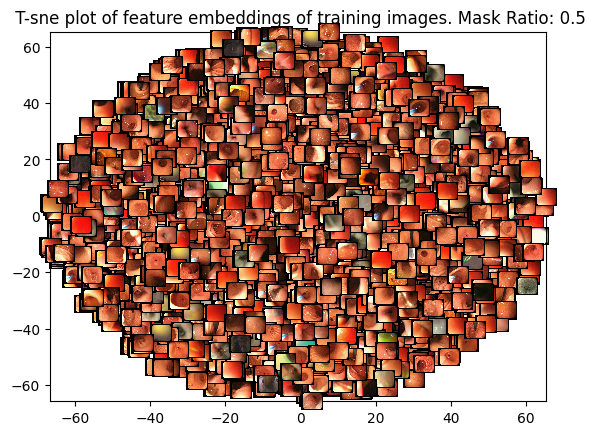

In [113]:
def plot_tsne(input_path, which_type):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    def getImage(path, zoom=.025):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Specify the directory containing the images
    image_directory = input_path

    # List all files in the directory
    files = os.listdir(image_directory)

    # Filter out the image files (assuming .jpg and .png extensions)
    image_files = [os.path.join(image_directory, f) for f in files if f.endswith(('.jpg', '.png'))]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Assuming 'embedding' is defined elsewhere in your code
    for x0, y0, path in zip(embedding[:, 0], embedding[:, 1], image_files):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    # Set the limits of the plot to ensure all images are visible
    # You might need to adjust these limits based on the range of your embedding coordinates
    ax.set_xlim(embedding[:, 0].min(), embedding[:, 0].max())
    ax.set_ylim(embedding[:, 1].min(), embedding[:, 1].max())
    from datetime import datetime
    now = datetime.now()
    timestamp = now.strftime("%y%m%d_%H%M")
    
    title = f" T-sne plot of feature embeddings of {which_type} images. Mask Ratio: {mask_ratio}"

    # Set the title of the plot
    ax.set_title(title)

    # Save the figure with the datetime stamp in the filename
    plt.savefig(f'./plots/tsne_time-{timestamp}_mask-{mask_ratio}_type-{which_type}.png')
    plt.show()

if tsne_plotting:
    if tsne_target == "training images":
        plot_tsne(pretrain_path_imgs, 'training')
    elif tsne_target == "validation images":
        plot_tsne(val_path_imgs,'validation')